<a href="https://colab.research.google.com/github/ramayer/google-colab-examples/blob/main/HelloWorld_Transformer_with_RoPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HelloWorld Transformer with RoPE

The simplest possible transformer with RoPE

In [4]:
%pip install --quiet einx

Using device: cpu

Training Model WITHOUT positional embedding...
Epoch 5/15, Loss: 0.005699
Epoch 10/15, Loss: 0.005348
Epoch 15/15, Loss: 0.004908

Training Model WITH RoPE positional embedding...
Epoch 5/15, Loss: 0.005531
Epoch 10/15, Loss: 0.004976
Epoch 15/15, Loss: 0.004541

Generating prediction snapshots...
Epoch 5/8, Loss: 0.004833
Epoch 5/8, Loss: 0.003945


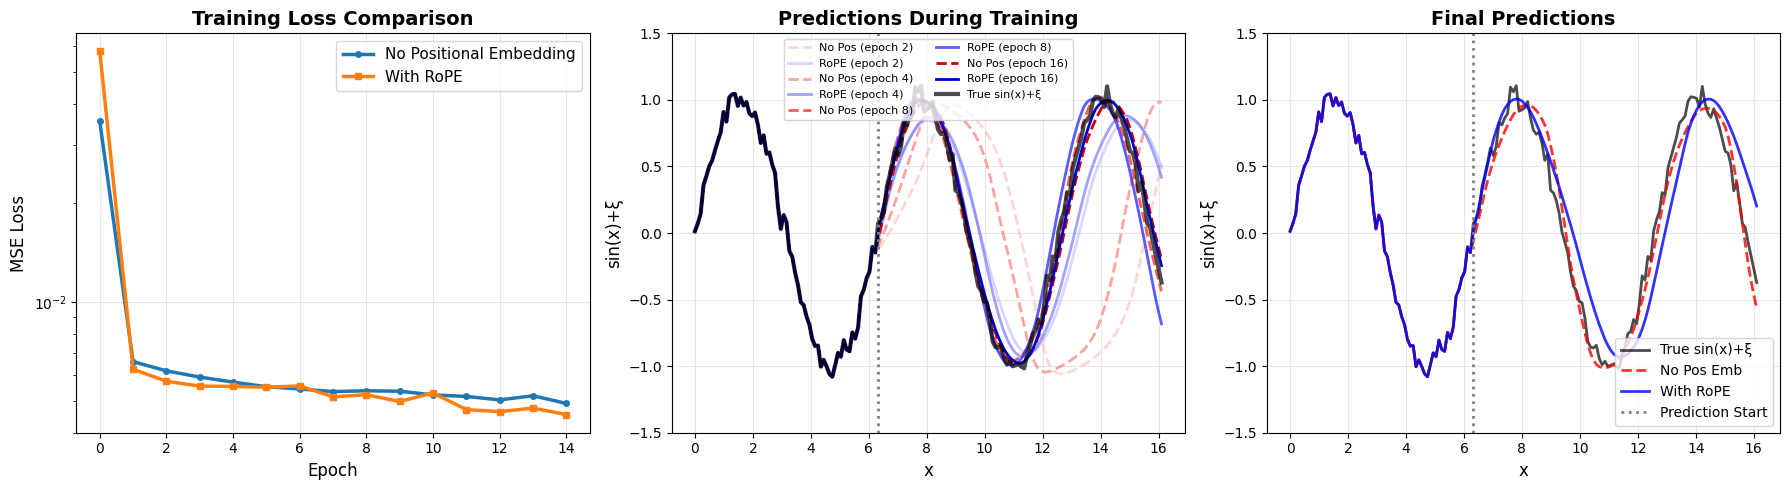


TRAINING COMPLETE!


In [5]:
"""
Minimal Transformer Demo: Predicting sin(x) with and without RoPE
Demonstrates transformer internals and why positional information matters.
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import einx

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =============================================================================
# 1. ROTARY POSITION EMBEDDING (RoPE) IMPLEMENTATION
# =============================================================================

def precompute_freqs_cis(dim: int, seq_len: int, theta: float = 10000.0):
    """Precompute RoPE rotation frequencies."""
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(seq_len, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # (seq_len, dim//2)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # e^(i*theta)
    return freqs_cis


def apply_rotary_emb(x, freqs_cis):
    """Apply rotary position embedding to a single tensor (Q or K)."""
    # Reshape to complex: (b, s, h, d) -> (b, s, h, d//2)
    x_complex = einx.rearrange("b s h (d c) -> b s h d c", x, c=2)
    x_complex = torch.view_as_complex(x_complex.float())

    # Broadcast freqs_cis and rotate
    freqs_cis = einx.rearrange("s d -> 1 s 1 d", freqs_cis[:x_complex.shape[1], :])
    x_rotated = x_complex * freqs_cis

    # Back to real: (b, s, h, d//2) -> (b, s, h, d)
    x_out = torch.view_as_real(x_rotated)
    x_out = einx.rearrange("b s h d c -> b s h (d c)", x_out)
    return x_out.type_as(x)


# =============================================================================
# 2. TRANSFORMER BUILDING BLOCKS
# =============================================================================

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention with optional RoPE."""

    def __init__(self, d_model, n_heads, use_rope=False):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.use_rope = use_rope

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x, freqs_cis=None, return_attention=False):
        b, s = x.shape[0], x.shape[1]

        # Project and reshape: (b, s, d) -> (b, s, h, d_head)
        Q = einx.rearrange("b s (h d) -> b s h d", self.q_proj(x), h=self.n_heads)
        K = einx.rearrange("b s (h d) -> b s h d", self.k_proj(x), h=self.n_heads)
        V = einx.rearrange("b s (h d) -> b s h d", self.v_proj(x), h=self.n_heads)

        # Apply RoPE if enabled (to Q and K independently)
        if self.use_rope and freqs_cis is not None:
            Q = apply_rotary_emb(Q, freqs_cis)
            K = apply_rotary_emb(K, freqs_cis)

        # Attention: (b, h, s, d_head)
        Q, K, V = [einx.rearrange("b s h d -> b h s d", t) for t in [Q, K, V]]

        scores = torch.matmul(Q, einx.rearrange("b h s d -> b h d s", K)) / np.sqrt(self.head_dim)

        # Apply causal mask (prevent attending to future positions)
        causal_mask = torch.triu(torch.ones(s, s, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(causal_mask, float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)

        # Merge heads: (b, h, s, d_head) -> (b, s, d)
        attn_output = einx.rearrange("b h s d -> b s (h d)", attn_output)
        output = self.o_proj(attn_output)

        if return_attention:
            return output, attn_weights
        return output


class FeedForward(nn.Module):
    """Position-wise feed-forward network."""

    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))


class TransformerBlock(nn.Module):
    """Transformer block: attention + feed-forward with residuals."""

    def __init__(self, d_model, n_heads, d_ff, use_rope=False):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, use_rope)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, freqs_cis=None, return_attention=False):
        # Attention with residual
        if return_attention:
            attn_out, attn_weights = self.attention(
                self.norm1(x), freqs_cis, return_attention=True
            )
            x = x + attn_out
            x = x + self.feed_forward(self.norm2(x))
            return x, attn_weights
        else:
            x = x + self.attention(self.norm1(x), freqs_cis)
            x = x + self.feed_forward(self.norm2(x))
            return x


class SimpleTransformer(nn.Module):
    """Simple transformer for time series prediction."""

    def __init__(self, d_model=64, n_heads=4, n_layers=2, d_ff=256,
                 seq_len=32, use_rope=False):
        super().__init__()
        self.d_model = d_model
        self.use_rope = use_rope

        # Input embedding (from 1D value to d_model dimensions)
        self.input_embedding = nn.Linear(1, d_model)

        # Precompute RoPE frequencies if needed
        if use_rope:
            self.register_buffer(
                "freqs_cis",
                precompute_freqs_cis(d_model // n_heads, seq_len)
            )

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, use_rope)
            for _ in range(n_layers)
        ])

        # Output projection
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x, return_attention=False):
        # x shape: (batch, seq_len, 1)
        x = self.input_embedding(x)  # (batch, seq_len, d_model)

        freqs_cis = self.freqs_cis if self.use_rope else None

        if return_attention:
            # Only return attention from first block for visualization
            x, attn_weights = self.blocks[0](x, freqs_cis, return_attention=True)
            for block in self.blocks[1:]:
                x = block(x, freqs_cis)
            x = self.output_proj(x)
            return x, attn_weights
        else:
            for block in self.blocks:
                x = block(x, freqs_cis)
            x = self.output_proj(x)
            return x


# =============================================================================
# 3. DATA GENERATION
# =============================================================================

class SinusoidDataset(Dataset):
    """Generate sin(x) sequences for next-step prediction."""

    def __init__(self, n_samples=1000, seq_len=64, noise_level=0.05):
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.noise_level = noise_level
        self.starts = np.random.uniform(0, 4 * np.pi, n_samples)
        self.freqs = np.random.uniform(0.8, 1.2, n_samples)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        start = self.starts[idx]
        freq = self.freqs[idx]
        x = np.linspace(start, start + 2*np.pi*freq, self.seq_len + 1)
        y = np.sin(x)

        if self.noise_level > 0:
            y = y + np.random.normal(0, self.noise_level, len(y))

        input_seq = torch.FloatTensor(y[:-1]).unsqueeze(-1)
        target_seq = torch.FloatTensor(y[1:]).unsqueeze(-1)

        return input_seq, target_seq


# =============================================================================
# 4. TRAINING FUNCTION
# =============================================================================

def train_model(model, train_loader, n_epochs=10, lr=0.001, device='cpu'):
    """Train the transformer model."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_input, batch_target in train_loader:
            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            optimizer.zero_grad()
            output = model(batch_input)
            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")

    return losses


# =============================================================================
# 5. TRAINING
# =============================================================================

# Hyperparameters
SEQ_LEN = 64
BATCH_SIZE = 32
N_EPOCHS = 15
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}\n")

# Create dataset with varying frequency sin waves
train_dataset = SinusoidDataset(n_samples=2000, seq_len=SEQ_LEN, noise_level=0.05)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create two models: one with RoPE, one without
print("="*60)
print("Training Model WITHOUT positional embedding...")
print("="*60)
model_no_pos = SimpleTransformer(
    d_model=64, n_heads=4, n_layers=2, d_ff=256,
    seq_len=SEQ_LEN, use_rope=False
)
losses_no_pos = train_model(model_no_pos, train_loader, n_epochs=N_EPOCHS, device=DEVICE)

print("\n" + "="*60)
print("Training Model WITH RoPE positional embedding...")
print("="*60)
model_with_rope = SimpleTransformer(
    d_model=64, n_heads=4, n_layers=2, d_ff=256,
    seq_len=SEQ_LEN, use_rope=True
)
losses_with_rope = train_model(model_with_rope, train_loader, n_epochs=N_EPOCHS, device=DEVICE)


# =============================================================================
# 6. VISUALIZATION
# =============================================================================

fig = plt.figure(figsize=(18, 5))

# Plot 1: Training curves
ax1 = plt.subplot(1, 3, 1)
plt.plot(losses_no_pos, label='No Positional Embedding', linewidth=2.5, marker='o', markersize=4)
plt.plot(losses_with_rope, label='With RoPE', linewidth=2.5, marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: Snapshot predictions at different epochs
ax2 = plt.subplot(1, 3, 2)

# Re-train and save snapshots
print("\nGenerating prediction snapshots...")
model_no_pos_snap = SimpleTransformer(d_model=64, n_heads=4, n_layers=2, d_ff=256,
                                       seq_len=SEQ_LEN, use_rope=False).to(DEVICE)
model_rope_snap = SimpleTransformer(d_model=64, n_heads=4, n_layers=2, d_ff=256,
                                     seq_len=SEQ_LEN, use_rope=True).to(DEVICE)

# Create test data with noise matching training distribution
n_test_points = SEQ_LEN + 100
test_x = np.linspace(0, 2*np.pi * (n_test_points / SEQ_LEN), n_test_points)
test_y_clean = np.sin(test_x)
test_y = test_y_clean + np.random.normal(0, 0.05, len(test_x))  # Add noise like training
test_context = torch.FloatTensor(test_y[:SEQ_LEN]).unsqueeze(0).unsqueeze(-1).to(DEVICE)

snapshot_epochs = [2, 4, 8, 16]
colors_no_pos = ['#ff9999', '#ff6666', '#ff3333', '#cc0000']
colors_rope = ['#9999ff', '#6666ff', '#3333ff', '#0000cc']

for epoch_idx, target_epoch in enumerate(snapshot_epochs):
    # Train to target epoch
    if epoch_idx == 0:
        epochs_to_train = target_epoch
    else:
        epochs_to_train = target_epoch - snapshot_epochs[epoch_idx - 1]

    if epochs_to_train > 0:
        train_model(model_no_pos_snap, train_loader, n_epochs=epochs_to_train, device=DEVICE)
        train_model(model_rope_snap, train_loader, n_epochs=epochs_to_train, device=DEVICE)

    # Generate predictions
    model_no_pos_snap.eval()
    model_rope_snap.eval()

    with torch.no_grad():
        context_no_pos = test_context.clone()
        context_rope = test_context.clone()
        preds_no_pos = test_y[:SEQ_LEN].tolist()
        preds_rope = test_y[:SEQ_LEN].tolist()

        for i in range(100):  # Predict much further
            pred_no_pos = model_no_pos_snap(context_no_pos)[:, -1:, :]
            pred_rope = model_rope_snap(context_rope)[:, -1:, :]
            preds_no_pos.append(pred_no_pos.cpu().item())
            preds_rope.append(pred_rope.cpu().item())
            # Update each context with its OWN predictions
            context_no_pos = torch.cat([context_no_pos[:, 1:, :], pred_no_pos], dim=1)
            context_rope = torch.cat([context_rope[:, 1:, :], pred_rope], dim=1)

    alpha = 0.4 + (epoch_idx * 0.2)
    plt.plot(test_x[:SEQ_LEN+100], preds_no_pos, '--', color=colors_no_pos[epoch_idx],
             linewidth=2, alpha=alpha, label=f'No Pos (epoch {target_epoch})')
    plt.plot(test_x[:SEQ_LEN+100], preds_rope, '-', color=colors_rope[epoch_idx],
             linewidth=2, alpha=alpha, label=f'RoPE (epoch {target_epoch})')

plt.plot(test_x, test_y, 'k-', linewidth=3, alpha=0.7, label='True sin(x)+ξ')
plt.axvline(x=test_x[SEQ_LEN], color='gray', linestyle=':', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)+ξ', fontsize=12)
plt.title('Predictions During Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.ylim(-1.5, 1.5)

# Plot 3: Final comparison
ax3 = plt.subplot(1, 3, 3)
model_no_pos.eval()
model_with_rope.eval()

with torch.no_grad():
    context_no_pos = test_context.clone()
    context_rope = test_context.clone()
    predictions_no_pos = test_y[:SEQ_LEN].tolist()
    predictions_rope = test_y[:SEQ_LEN].tolist()

    for i in range(100):  # Predict much further
        pred_no_pos = model_no_pos(context_no_pos)[:, -1:, :]
        pred_rope = model_with_rope(context_rope)[:, -1:, :]
        predictions_no_pos.append(pred_no_pos.cpu().item())
        predictions_rope.append(pred_rope.cpu().item())
        # Update each context with its OWN predictions
        context_no_pos = torch.cat([context_no_pos[:, 1:, :], pred_no_pos], dim=1)
        context_rope = torch.cat([context_rope[:, 1:, :], pred_rope], dim=1)

plt.plot(test_x, test_y, 'k-', label='True sin(x)+ξ', linewidth=2, alpha=0.7)
plt.plot(test_x[:SEQ_LEN+100], predictions_no_pos, 'r--',
         label='No Pos Emb', linewidth=2, alpha=0.8)
plt.plot(test_x[:SEQ_LEN+100], predictions_rope, 'b-',
         label='With RoPE', linewidth=2, alpha=0.8)
plt.axvline(x=test_x[SEQ_LEN], color='gray', linestyle=':', linewidth=2, label='Prediction Start')
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)+ξ', fontsize=12)
plt.title('Final Predictions', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

In [ ]:
# =============================================================================
# ATTENTION PATTERN VISUALIZATION
# =============================================================================

"""
Visualize attention patterns to see how RoPE affects what each position attends to.
Without positional info, attention patterns are position-invariant.
With RoPE, positions attend differently based on their location.
"""

model_no_pos.eval()
model_with_rope.eval()

# Generate a single test sequence
test_start = np.pi
test_x = np.linspace(test_start, test_start + 2*np.pi, SEQ_LEN)
test_y = np.sin(test_x)
test_input = torch.FloatTensor(test_y).unsqueeze(0).unsqueeze(-1).to(DEVICE)

# Extract attention weights from first layer
with torch.no_grad():
    _, attn_no_pos = model_no_pos(test_input, return_attention=True)
    _, attn_rope = model_with_rope(test_input, return_attention=True)

# Average across heads: (batch, n_heads, seq_len, seq_len) -> (seq_len, seq_len)
attn_no_pos = attn_no_pos[0].mean(dim=0).cpu().numpy()
attn_rope = attn_rope[0].mean(dim=0).cpu().numpy()

# Plot attention patterns
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# No positional embedding
im1 = axes[0].imshow(attn_no_pos, cmap='viridis', aspect='auto')
axes[0].set_title('No Positional Embedding', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Key Position', fontsize=11)
axes[0].set_ylabel('Query Position', fontsize=11)
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# With RoPE
im2 = axes[1].imshow(attn_rope, cmap='viridis', aspect='auto')
axes[1].set_title('With RoPE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Key Position', fontsize=11)
axes[1].set_ylabel('Query Position', fontsize=11)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (shows diagonal structure from RoPE)
diff = attn_rope - attn_no_pos
im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
axes[2].set_title('Difference (RoPE - No Pos)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Key Position', fontsize=11)
axes[2].set_ylabel('Query Position', fontsize=11)
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Without pos embedding: attention is nearly uniform/position-invariant")
print("• With RoPE: attention has diagonal structure (nearby positions matter more)")
print("• Difference map: shows RoPE creates position-dependent attention patterns")

# from chatgpt

epoch 0 loss 0.3447
epoch 5 loss 0.0797
epoch 10 loss 0.1226
epoch 15 loss 0.0501


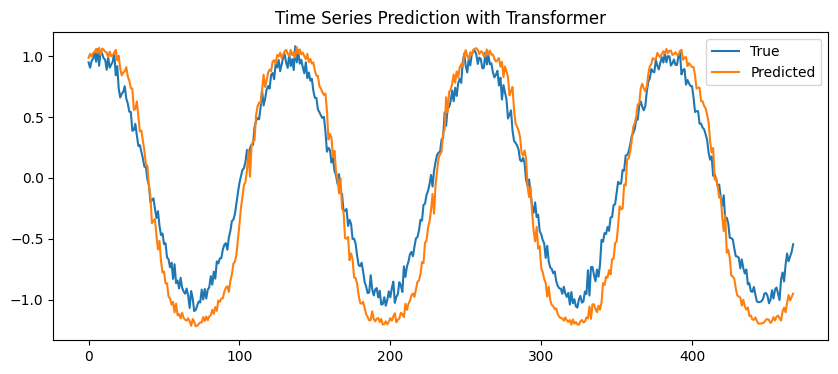

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# ----- 1. Synthetic Data -----
torch.manual_seed(0)
N = 2000
x = torch.linspace(0, 100, N)
y = torch.sin(x) + 0.05 * torch.randn(N)

seq_len = 32

def make_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len-1])
        ys.append(data[i+seq_len-1])
    return torch.stack(xs), torch.stack(ys)

X, Y = make_sequences(y, seq_len)  # shape: [N, seq_len-1], [N]
X = X.unsqueeze(-1)                # [N, seq_len-1, 1]
Y = Y.unsqueeze(-1)                # [N, 1]

train_X, train_Y = X[:1500], Y[:1500]
test_X, test_Y = X[1500:], Y[1500:]

# ----- 2. Positional Encoding -----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ----- 3. Transformer Model -----
class TinyTimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        x = self.input_proj(x)
        x = self.pos_enc(x)

        # causal mask (triangular)
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        x = self.encoder(x, mask=mask)

        # predict based on last token's hidden state
        return self.output(x[:, -1, :])

model = TinyTimeSeriesTransformer()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ----- 4. Training Loop -----
for epoch in range(20):
    model.train()
    pred = model(train_X)
    loss = F.mse_loss(pred, train_Y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        print(f"epoch {epoch} loss {loss.item():.4f}")

# ----- 5. Evaluate -----
model.eval()
with torch.no_grad():
    preds = model(test_X).squeeze().numpy()

plt.figure(figsize=(10,4))
plt.plot(range(len(test_Y)), test_Y.squeeze(), label='True')
plt.plot(range(len(preds)), preds, label='Predicted')
plt.legend(); plt.title("Time Series Prediction with Transformer")
plt.show()


In [ ]:
%pip install --quiet torchview

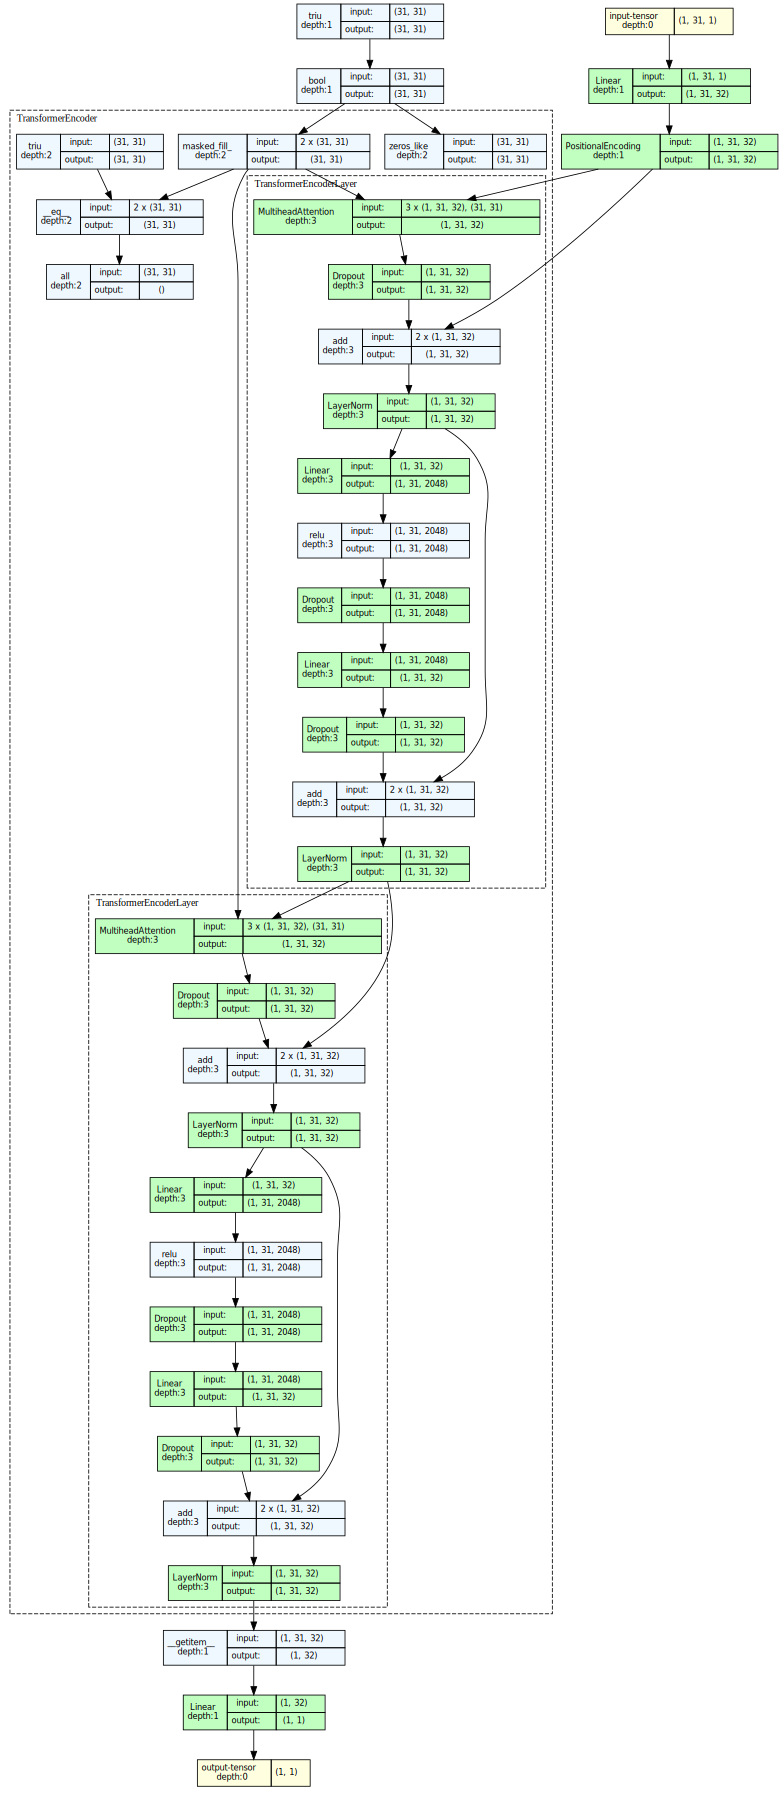

In [ ]:
from torchview import draw_graph

# Use a small batch of your training data to trace the model
example_input = train_X[:1]  # shape [1, seq_len-1, 1]

model_graph = draw_graph(
    model,
    input_data=example_input,
    expand_nested=True,
    save_graph=True,
    graph_name="transformer_ts"
)

model_graph.visual_graph  # displays in notebook


PE Epoch 0: 0.5875
PE Epoch 2: 0.1401
PE Epoch 4: 0.1220
PE Epoch 6: 0.1212
RoPE Epoch 0: 0.3399
RoPE Epoch 2: 0.1839
RoPE Epoch 4: 0.0544
RoPE Epoch 6: 0.1127


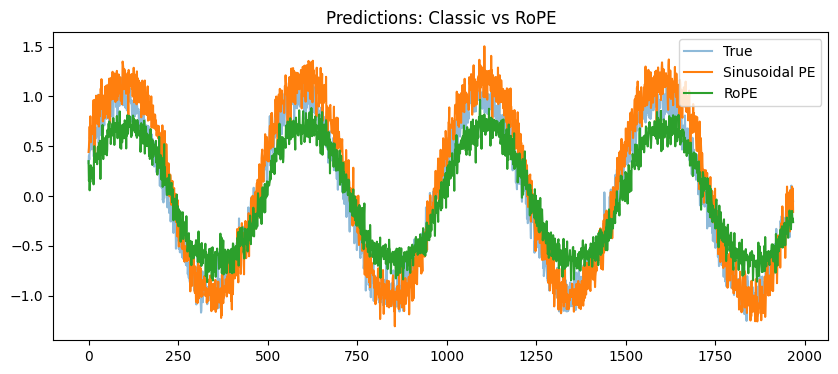

IndexError: list index out of range

In [ ]:
# 🧠 Time-Series Transformer: Sinusoidal PE vs. RoPE — All in One Cell

import torch, torch.nn as nn, math, matplotlib.pyplot as plt
torch.manual_seed(0)

# === Generate a noisy sine wave ===
N = 2000
x = torch.linspace(0, 8 * math.pi, N)
y = torch.sin(x) + 0.1 * torch.randn_like(x)

seq_len = 32
X, Y = [], []
for i in range(len(y) - seq_len):
    X.append(y[i:i+seq_len])
    Y.append(y[i+seq_len])
X = torch.stack(X).unsqueeze(-1)
Y = torch.stack(Y).unsqueeze(-1)

# === Sinusoidal PE ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

# === RoPE helper ===
def apply_rope(x, base=10000):
    seq_len, d_model = x.shape[1], x.shape[2]
    half = d_model // 2
    freqs = torch.exp(-torch.arange(0, half, dtype=torch.float32, device=x.device)
                      * math.log(base) / half)
    pos = torch.arange(seq_len, dtype=torch.float32, device=x.device)
    angles = pos[:, None] * freqs[None, :]
    sin, cos = angles.sin(), angles.cos()
    x1, x2 = x[..., :half], x[..., half:]
    return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

# === Base Transformer block that captures attention ===
class SimpleTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, rope=False):
        super().__init__()
        self.d_model, self.rope = d_model, rope
        self.input_proj = nn.Linear(1, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=128, batch_first=True)
            for _ in range(num_layers)
        ])
        if not rope:
            self.pos = PositionalEncoding(d_model)
        self.fc_out = nn.Linear(d_model, 1)
        self.attn_maps = []

        # Attach hooks to capture attention weights
        for layer in self.layers:
            layer.self_attn.register_forward_hook(self._capture_attn)

    def _capture_attn(self, module, input, output):
        if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
            self.attn_maps.append(output[1].detach().cpu())

    def forward(self, x):
        self.attn_maps.clear()
        x = self.input_proj(x)
        if not self.rope:
            x = self.pos(x)
        for layer in self.layers:
            if self.rope:
                # apply RoPE to q/k inside MultiheadAttention
                q = apply_rope(x)
                k = apply_rope(x)
                x, _ = layer.self_attn(q, k, x, need_weights=True)
                x = layer.norm1(x + layer.dropout1(x))
                x = layer.norm2(x + layer.dropout2(
                    layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
                ))
            else:
                x = layer(x)
        return self.fc_out(x[:, -1, :])

# === Train helper ===
def train_model(model, X, Y, epochs=8, lr=1e-3):
    opt, loss_fn = torch.optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    for e in range(epochs):
        opt.zero_grad()
        loss = loss_fn(model(X), Y)
        loss.backward(); opt.step()
        if e % 2 == 0:
            print(f"{'RoPE' if model.rope else 'PE'} Epoch {e}: {loss.item():.4f}")

# === Train both models ===
model_pe = SimpleTransformer(rope=False)
model_rope = SimpleTransformer(rope=True)
train_model(model_pe, X, Y)
train_model(model_rope, X, Y)

# === Compare predictions ===
with torch.no_grad():
    pred_pe = model_pe(X).squeeze()
    pred_rope = model_rope(X).squeeze()

plt.figure(figsize=(10,4))
plt.plot(Y.squeeze(), label='True', alpha=0.5)
plt.plot(pred_pe, label='Sinusoidal PE')
plt.plot(pred_rope, label='RoPE')
plt.title("Predictions: Classic vs RoPE")
plt.legend(); plt.show()

# === Visualize attention maps (first layer) ===
def plot_attention_maps(model, title):
    if not model.attn_maps:
        _ = model(X[:1])  # forward one sample to populate attn maps
    attn = model.attn_maps[0][0]  # [heads, seq, seq]
    n_heads = attn.shape[0]
    fig, axes = plt.subplots(1, n_heads, figsize=(12,3))
    fig.suptitle(title)
    for h in range(n_heads):
        axes[h].imshow(attn[h], origin='lower', aspect='auto', cmap='viridis')
        axes[h].set_title(f"Head {h}")
        axes[h].set_xlabel("Key positions")
        axes[h].set_ylabel("Query positions")
    plt.show()

plot_attention_maps(model_pe, "Classic Sinusoidal PE — Attention")
plot_attention_maps(model_rope, "RoPE — Attention")
